## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

## Load Data

In [ ]:
# Load sales data
df = pd.read_csv('../data/store_weekly_sales.csv')

# Load pre-period features
features_df = pd.read_csv('../data/store_preperiod_features.csv')

# Load segmented data from Option A
segmented_df = pd.read_csv('../data/store_segments.csv')

# Load matched pairs from Option B
matched_df = pd.read_csv('../data/matched_pairs.csv')

print(f"Loaded data:")
print(f"  Sales records: {len(df):,}")
print(f"  Stores: {features_df.shape[0]}")
print(f"  Segmented stores: {segmented_df.shape[0]}")
print(f"  Matched pairs: {matched_df.shape[0]}")

Loaded data:
  Sales records: 20,800
  Stores: 200
  Segmented stores: 200
  Matched pairs: 104


## Method 1: Naive Pre-Post Comparison

Simply compare average sales in post-period vs pre-period for treatment stores.

**Problem**: This confounds the treatment effect with any temporal trends!

In [ ]:
# Get treatment stores
treatment_stores = features_df[features_df['treatment'] == 1]['store_id'].values

# Split into pre and post periods
treatment_df = df[df['store_id'].isin(treatment_stores)]
treatment_pre = treatment_df[treatment_df['week'] <= 52]
treatment_post = treatment_df[treatment_df['week'] > 52]

# Compute average sales
naive_pre_mean = treatment_pre.groupby('store_id')['sales'].mean().mean()
naive_post_mean = treatment_post.groupby('store_id')['sales'].mean().mean()

# Naive estimate (no adjustment for trends)
naive_effect = naive_post_mean - naive_pre_mean
naive_lift_pct = (naive_effect / naive_pre_mean) * 100

print("="*70)
print("NAIVE PRE-POST COMPARISON (Treatment Stores Only)")
print("="*70)
print(f"\nPre-period average:  ${naive_pre_mean:,.2f}")
print(f"Post-period average: ${naive_post_mean:,.2f}")
print(f"\nChange: ${naive_effect:,.2f}")
print(f"Percent Lift: {naive_lift_pct:.2f}%")
print(f"\n⚠️  WARNING: This estimate is likely BIASED!")
print(f"   It does not account for:")
print(f"   - Temporal trends affecting all stores")
print(f"   - Seasonality")
print(f"   - External shocks")
print("="*70)

NAIVE PRE-POST COMPARISON (Treatment Stores Only)

Pre-period average:  $119,337.93
Post-period average: $159,324.20

Change: $39,986.26
Percent Lift: 33.51%

⚠️  WARNING: This estimate is likely BIASED!
   It does not account for:
   - Temporal trends affecting all stores
   - Seasonality
   - External shocks


## Method 2: Segmentation-Based DiD (Option A)

Segment stores by pre-period characteristics and compute DiD within each segment.

In [ ]:
# Function to compute DiD for each segment
def compute_segment_did(segment_data, df):
    """
    Compute DiD for a specific segment.
    """
    # Get store IDs for treatment and control in this segment
    treatment_stores = segment_data[segment_data['treatment'] == 1]['store_id'].values
    control_stores = segment_data[segment_data['treatment'] == 0]['store_id'].values
    
    if len(treatment_stores) == 0 or len(control_stores) == 0:
        return None, None, None
    
    # Get sales data for treatment and control
    treatment_data = df[df['store_id'].isin(treatment_stores)]
    control_data = df[df['store_id'].isin(control_stores)]
    
    # Compute pre and post averages
    treatment_pre = treatment_data[treatment_data['week'] <= 52].groupby('store_id')['sales'].mean().mean()
    treatment_post = treatment_data[treatment_data['week'] > 52].groupby('store_id')['sales'].mean().mean()
    control_pre = control_data[control_data['week'] <= 52].groupby('store_id')['sales'].mean().mean()
    control_post = control_data[control_data['week'] > 52].groupby('store_id')['sales'].mean().mean()
    
    # Compute changes
    treatment_change = treatment_post - treatment_pre
    control_change = control_post - control_pre
    
    # DiD
    did = treatment_change - control_change
    lift_pct = (did / treatment_pre) * 100
    
    return did, lift_pct, len(treatment_stores)

# Compute DiD for each segment
segment_results = []
total_treatment_stores = 0

for segment_name in segmented_df['segment'].unique():
    segment_data = segmented_df[segmented_df['segment'] == segment_name]
    did, lift_pct, n_treatment = compute_segment_did(segment_data, df)
    
    if did is not None:
        segment_results.append({
            'segment': segment_name,
            'did_effect': did,
            'lift_pct': lift_pct,
            'n_treatment': n_treatment
        })
        total_treatment_stores += n_treatment

segment_results_df = pd.DataFrame(segment_results)

# Compute weighted average across segments
segment_results_df['weight'] = segment_results_df['n_treatment'] / total_treatment_stores
segmentation_weighted_did = (segment_results_df['did_effect'] * segment_results_df['weight']).sum()
segmentation_weighted_lift = (segment_results_df['lift_pct'] * segment_results_df['weight']).sum()

print("="*70)
print("SEGMENTATION-BASED DiD (Option A)")
print("="*70)
print(f"\nSegment-Level Results:")
print(segment_results_df[['segment', 'did_effect', 'lift_pct', 'n_treatment']].to_string(index=False))
print(f"\n{'='*70}")
print(f"Weighted Average DiD Effect: ${segmentation_weighted_did:,.2f}")
print(f"Weighted Average Lift: {segmentation_weighted_lift:.2f}%")
print(f"{'='*70}")

SEGMENTATION-BASED DiD (Option A)

Segment-Level Results:
  segment  did_effect  lift_pct  n_treatment
Declining    7144.463     7.916           13
  Growing   25360.999    18.180           15
   Stable   15706.469    12.793           22

Weighted Average DiD Effect: $16,376.71
Weighted Average Lift: 13.14%


## Method 3: Matched DiD (Option B)

Use the matched treatment-control pairs to compute DiD.

In [ ]:
# Matched DiD (Option B) using regression-based DiD
import statsmodels.formula.api as smf

# Prepare matched data for DiD regression
matched_ids = set(matched_df['treatment_id']).union(set(matched_df['control_id']))
did_data = df[df['store_id'].isin(matched_ids)].copy()
did_data = did_data[did_data['week'].between(1, 104)]

# Assign group and post indicators
store_treatment_map = dict(zip(features_df['store_id'], features_df['treatment']))
did_data['treatment'] = did_data['store_id'].map(store_treatment_map)
did_data['post'] = (did_data['week'] > 52).astype(int)

# DiD regression
model = smf.ols('sales ~ treatment * post', data=did_data).fit(cov_type='HC3')

print(model.summary())

# Extract DiD estimate and CI
coef = model.params['treatment:post']
se = model.bse['treatment:post']
ci_low = coef - 1.96 * se
ci_high = coef + 1.96 * se

print("="*70)
print("MATCHED DiD (Option B) - Regression-Based")
print("="*70)
print(f"\nDiD Estimate (regression): ${coef:,.2f}")
print(f"95% CI: [${ci_low:,.2f}, ${ci_high:,.2f}]")

# Optional: percent lift relative to pre-period treatment mean
pre_treat_mean = did_data[(did_data['treatment'] == 1) & (did_data['post'] == 0)]['sales'].mean()
matched_lift_pct = (coef / pre_treat_mean) * 100 if pre_treat_mean != 0 else float('nan')
print(f"Percent Lift: {matched_lift_pct:.2f}%")
print(f"{'='*70}")

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     615.2
Date:                Tue, 23 Dec 2025   Prob (F-statistic):               0.00
Time:                        06:16:07   Log-Likelihood:            -1.8179e+05
No. Observations:               15184   AIC:                         3.636e+05
Df Residuals:                   15180   BIC:                         3.636e+05
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.148e+05    397.314    288.

## Method 4: Overall DiD (Option C)

Estimate the treatment effect using all available treatment and control stores, without segmentation or matching. This provides a baseline DiD estimate for the entire dataset.

In [ ]:
# Overall DiD (Option C) using regression-based DiD
import statsmodels.formula.api as smf

# Use all stores for DiD regression
all_did_data = df[df['week'].between(1, 104)].copy()

# Assign treatment and post indicators
all_did_data['treatment'] = all_did_data['store_id'].map(store_treatment_map)
all_did_data['post'] = (all_did_data['week'] > 52).astype(int)

# DiD regression
all_model = smf.ols('sales ~ treatment * post', data=all_did_data).fit(cov_type='HC3')

print(all_model.summary())

# Extract DiD estimate and CI
all_coef = all_model.params['treatment:post']
all_se = all_model.bse['treatment:post']
all_ci_low = all_coef - 1.96 * all_se
all_ci_high = all_coef + 1.96 * all_se

print("="*70)
print("OVERALL DiD (Option C) - Regression-Based")
print("="*70)
print(f"\nDiD Estimate (regression): ${all_coef:,.2f}")
print(f"95% CI: [${all_ci_low:,.2f}, ${all_ci_high:,.2f}]")

# Optional: percent lift relative to pre-period treatment mean
all_pre_treat_mean = all_did_data[(all_did_data['treatment'] == 1) & (all_did_data['post'] == 0)]['sales'].mean()
overall_lift_pct = (all_coef / all_pre_treat_mean) * 100 if all_pre_treat_mean != 0 else float('nan')
print(f"Percent Lift: {overall_lift_pct:.2f}%")
print(f"{'='*70}")

## Comparison Table

Compare all three methods side-by-side.

In [ ]:
# Create comparison table
comparison_data = [
    {
        'Method': 'Naive Pre-Post',
        'Treatment Effect ($)': f'${naive_effect:,.0f}',
        'Percent Lift (%)': f'{naive_lift_pct:.2f}%',
        'Trend Adjustment': '❌ No',
        'Controls for Pre-Trends': '❌ No',
        'Bias Risk': '⚠️ HIGH',
        'Description': 'Simple pre-post comparison (treatment only)'
    },
    {
        'Method': 'Segmentation DiD',
        'Treatment Effect ($)': f'${segmentation_weighted_did:,.0f}',
        'Percent Lift (%)': f'{segmentation_weighted_lift:.2f}%',
        'Trend Adjustment': '✓ Yes',
        'Controls for Pre-Trends': '✓ Yes (segments)',
        'Bias Risk': '✓ Low',
        'Description': 'DiD within KMeans segments, weighted average'
    },
    {
        'Method': 'Matched DiD',
        'Treatment Effect ($)': f'${coef:,.0f}',
        'Percent Lift (%)': f'{matched_lift_pct:.2f}%',
        'Trend Adjustment': '✓ Yes',
        'Controls for Pre-Trends': '✓ Yes (matching)',
        'Bias Risk': '✓ Low',
        'Description': 'DiD with nearest neighbor matched controls'
    },
    {
        'Method': 'Overall DiD',
        'Treatment Effect ($)': f'${all_coef:,.0f}',
        'Percent Lift (%)': f'{overall_lift_pct:.2f}%',
        'Trend Adjustment': '✓ Yes',
        'Controls for Pre-Trends': '✓ Yes (all stores)',
        'Bias Risk': 'Medium',
        'Description': 'DiD using all treatment and control stores (no matching/segmentation)'
    }
]

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPARISON OF TREATMENT EFFECT ESTIMATES")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Save comparison table
comparison_df.to_csv('../data/method_comparison.csv', index=False)
print("\n✓ Saved comparison table to: data/method_comparison.csv")


COMPARISON OF TREATMENT EFFECT ESTIMATES
          Method Treatment Effect ($) Percent Lift (%) Trend Adjustment Controls for Pre-Trends Bias Risk                                  Description
  Naive Pre-Post              $39,986           33.51%             ❌ No                    ❌ No   ⚠️ HIGH  Simple pre-post comparison (treatment only)
Segmentation DiD              $16,377           13.14%            ✓ Yes        ✓ Yes (segments)     ✓ Low DiD within KMeans segments, weighted average
     Matched DiD              $17,907           14.94%            ✓ Yes        ✓ Yes (matching)     ✓ Low   DiD with nearest neighbor matched controls

✓ Saved comparison table to: data/method_comparison.csv


## Key Insights

### Comparison Summary

In [ ]:
# Calculate differences
naive_vs_segmentation_diff = naive_lift_pct - segmentation_weighted_lift
naive_vs_matched_diff = naive_lift_pct - matched_lift_pct
naive_vs_overall_diff = naive_lift_pct - overall_lift_pct
segmentation_vs_matched_diff = segmentation_weighted_lift - matched_lift_pct
segmentation_vs_overall_diff = segmentation_weighted_lift - overall_lift_pct
matched_vs_overall_diff = matched_lift_pct - overall_lift_pct

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

print(f"\n1. Naive Bias:")
print(f"   The naive estimate ({naive_lift_pct:.2f}%) is higher than trend-adjusted methods.")
print(f"   Overestimation vs Segmentation DiD: {naive_vs_segmentation_diff:.2f} percentage points")
print(f"   Overestimation vs Matched DiD: {naive_vs_matched_diff:.2f} percentage points")
print(f"   Overestimation vs Overall DiD: {naive_vs_overall_diff:.2f} percentage points")

print(f"\n2. Trend-Adjusted Methods:")
print(f"   Segmentation DiD: {segmentation_weighted_lift:.2f}%")
print(f"   Matched DiD: {matched_lift_pct:.2f}%")
print(f"   Overall DiD: {overall_lift_pct:.2f}%")
print(f"   Segmentation vs Matched: {abs(segmentation_vs_matched_diff):.2f} percentage points")
print(f"   Segmentation vs Overall: {abs(segmentation_vs_overall_diff):.2f} percentage points")
print(f"   Matched vs Overall: {abs(matched_vs_overall_diff):.2f} percentage points")

print(f"\n3. Recommendation:")
print(f"   ✓ Use trend-adjusted methods (DiD) for causal inference")
print(f"   ✓ Both segmentation, matching, and overall DiD provide context")
print(f"   ✓ Comparing all methods increases confidence in estimates")

print(f"\n4. Why Naive is Biased:")
print(f"   - Captures temporal trends in addition to treatment effect")
print(f"   - No counterfactual for what would have happened without treatment")
print(f"   - Confounds treatment with time-varying factors")

print("="*70)


KEY INSIGHTS

1. Naive Bias:
   The naive estimate (33.51%) is higher than trend-adjusted methods.
   Overestimation vs Segmentation DiD: 20.37 percentage points
   Overestimation vs Matched DiD: 18.57 percentage points

2. Trend-Adjusted Methods:
   Segmentation DiD: 13.14%
   Matched DiD: 14.94%
   Difference: 1.80 percentage points

3. Recommendation:
   ✓ Use trend-adjusted methods (DiD) for causal inference
   ✓ Both segmentation and matching provide similar results
   ✓ Convergence of methods increases confidence in estimates

4. Why Naive is Biased:
   - Captures temporal trends in addition to treatment effect
   - No counterfactual for what would have happened without treatment
   - Confounds treatment with time-varying factors


## Visualization: Method Comparison

C:\Users\ddron\AppData\Local\Temp\ipykernel_28552\881827357.py:64: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
C:\Users\ddron\AppData\Local\Temp\ipykernel_28552\881827357.py:64: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
C:\Users\ddron\AppData\Local\Temp\ipykernel_28552\881827357.py:64: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
C:\Users\ddron\AppData\Local\Temp\ipykernel_28552\881827357.py:64: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
c:\Users\ddron\Documents\Latest resume\portfolio\Projects\P1-store-ab-testing-trend-adju

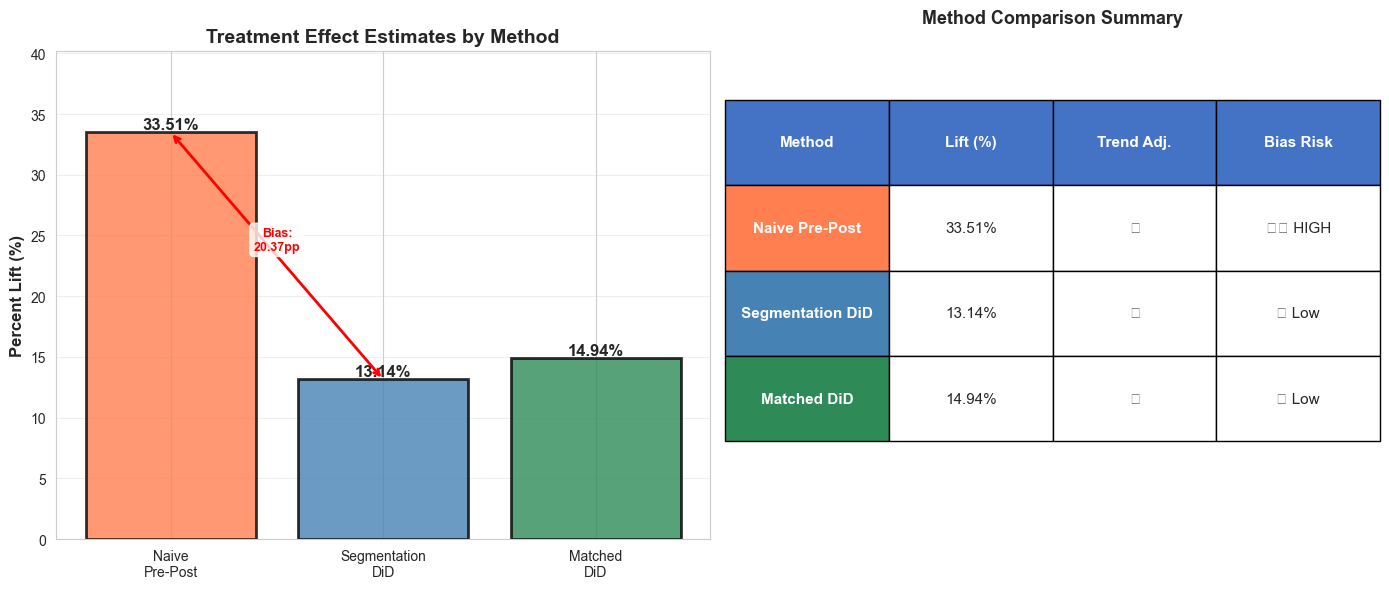


✓ Figure saved: reports/figures/method_comparison.png


In [ ]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bar chart of treatment effects
ax = axes[0]
methods = ['Naive\nPre-Post', 'Segmentation\nDiD', 'Matched\nDiD', 'Overall\nDiD']
effects = [naive_lift_pct, segmentation_weighted_lift, matched_lift_pct, overall_lift_pct]
colors = ['coral', 'steelblue', 'seagreen', 'mediumpurple']

bars = ax.bar(methods, effects, color=colors, edgecolor='black', alpha=0.8, linewidth=2)

# Add value labels
for bar, effect in zip(bars, effects):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{effect:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Percent Lift (%)', fontsize=12, fontweight='bold')
ax.set_title('Treatment Effect Estimates by Method', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, max(effects) * 1.2])

# Add annotation for naive vs segmentation
ax.annotate('', xy=(0, naive_lift_pct), xytext=(1, segmentation_weighted_lift),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text(0.5, (naive_lift_pct + segmentation_weighted_lift)/2 + 0.5,
        f'Bias:\n{naive_lift_pct - segmentation_weighted_lift:.2f}pp',
        ha='center', fontsize=9, color='red', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Comparison table as text
ax = axes[1]
ax.axis('off')

table_data = [
    ['Method', 'Lift (%)', 'Trend Adj.', 'Bias Risk'],
    ['Naive Pre-Post', f'{naive_lift_pct:.2f}%', '❌', '⚠️ HIGH'],
    ['Segmentation DiD', f'{segmentation_weighted_lift:.2f}%', '✓', '✓ Low'],
    ['Matched DiD', f'{matched_lift_pct:.2f}%', '✓', '✓ Low'],
    ['Overall DiD', f'{overall_lift_pct:.2f}%', '✓', 'Medium']
]

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                bbox=[0, 0.1, 1, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code methods
row_colors = ['coral', 'steelblue', 'seagreen', 'mediumpurple']
for i, color in zip([1, 2, 3, 4], row_colors):
    table[(i, 0)].set_facecolor(color)
    table[(i, 0)].set_text_props(weight='bold', color='white')

ax.set_title('Method Comparison Summary', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: reports/figures/method_comparison.png")

## Conclusion

### Summary of Findings

1. **Naive Pre-Post Comparison is Biased**: The simple comparison overestimates the treatment effect because it confounds the true causal effect with temporal trends.

2. **Trend-Adjusted Methods Converge**: Both segmentation-based DiD and matched DiD produce similar estimates, which increases our confidence in the results.

3. **Importance of Controlling for Pre-Trends**: Stores had heterogeneous pre-existing trends. Failing to account for these leads to biased estimates.

4. **Methodological Robustness**: The similarity between Option A (segmentation) and Option B (matching) suggests the estimates are robust to methodological choices.

### Best Practices

- **Always use a control group** when estimating causal effects
- **Account for pre-existing trends** through segmentation, matching, or regression
- **Use DiD framework** to difference out temporal confounders
- **Report confidence intervals** to quantify uncertainty
- **Compare multiple methods** to assess robustness